In [1]:
from keras.models import load_model
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import os
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

2022-12-06 17:14:40.369055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:14:41.474047: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/external/libraries/cudnn-linux-x86_64-8.4.1.50_cuda11.6-archive/lib:/sw/spack/delta-2022-03/apps/cuda/11.6.1-gcc-11.2.0-vglutoe/extras/CUPTI/lib64:/sw/spack/delta-2022-03/apps/cuda/11.6.1-gcc-11.2.0-vglutoe/lib64:/sw/spack/delta-2022-03/apps/openmpi/4.1.2-gcc-11.2.0-37px7gc/lib:/sw/spack/delta-2022-03/apps/ucx/1.11.2-gcc-11.2.0-pymppfm/lib:/sw/spack/delta-2022-03/apps/gcc/11.2.0-gcc-8.4.1-fxgns

In [2]:
## List of models
print("\n".join([f for f in os.listdir("../../models/TopoDNN/trained_models/")]))

topodnnmodel_pt
topodnnmodel_pt0
topodnnmodel_v3
topodnnmodel_standardize_pt
topodnnmodel_30
topodnnmodel_v1
topodnnmodel_v2
topodnnmodel_v4
topodnnmodel


In [3]:
# #Can change to any suffix after 'topodnnmodel' from the list above, keep the underscore in the mode name
mode = '' # '_pt0'
# #Load model
model = load_model("../../models/TopoDNN/trained_models/topodnnmodel" + mode)
model.summary()

2022-12-06 17:14:44.642602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:14:45.137319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38261 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:85:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               27300     
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               30702     
                                                                 
 activation_1 (Activation)   (None, 102)               0         
                                                                 
 dense_2 (Dense)             (None, 12)                1236      
                                                                 
 activation_2 (Activation)   (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 7

In [4]:
#Loading data
df_test = pd.read_pickle("../../datasets/topoprocessed/test.pkl")
labels = np.array(df_test.loc[:,df_test.columns == 'is_signal_new']).reshape(-1)
df_test = df_test.loc[:,df_test.columns != 'is_signal_new']

if mode == '_pt0':
    #Get rid of pt_0 column
    df_test = df_test.loc[:, df_test.columns != 'pt_0']
elif mode == '_pt':
    pt_cols = [col for col in df_test.columns if 'pt' in col]
    df_test = df_test.drop(pt_cols, axis=1)
elif mode == '_30':
    df_test = df_test.iloc[:,:30]
elif mode == '_standardize_pt':
    pt_cols = [col for col in df_test.columns if 'pt' in col]
    df_test[pt_cols] = (df_test[pt_cols] - df_test[pt_cols].mean())/df_test[pt_cols].std()


feats = np.array(df_test)
means = np.array(df_test.mean(0))
feat_names = list(df_test.columns)


print("Features shape: ", feats.shape)
print("Means shape: ", means.shape)
print("Results shape: ", labels.shape)

Features shape:  (404000, 90)
Means shape:  (90,)
Results shape:  (404000,)


In [5]:
def eval(model, mask_index = -1, mask_mode = 'mean'):
    data = np.copy(feats)
    if mask_index >= 0 and mask_index < len(feat_names):
        if mask_mode == 'mean':
            data[:, mask_index] = means[mask_index]
        else:
            data[:, mask_index] = 0.
    return model(data)

def eval2(model, mask_index = -1, mask_mode = 'mean'):
    data = np.copy(feats)
    if mask_index >= 0 and mask_index < len(feat_names):
        if mask_mode == 'mean':
            data[:, mask_index] = means[mask_index]
        else:
            data[:, mask_index] = 0.
    Nlayers = len(model.layers)
    for ii, layer in enumerate(model.layers):
        data = layer(data)
        if ii == Nlayers - 2:
            presig = np.array(data)
        if ii == Nlayers - 1:
            sig = np.array(data)
    return presig, sig

def dAUC_chart(dAUC_vals, tags, tag, save=False):
    tag = "baseline" if tag == "" else tag.strip('_')
    dAUC_vals = dAUC_vals[::-1]
    tags = tags[::-1]
    pos = np.arange(len(dAUC_vals))
    if len(tags) < 10:
        plt.figure(figsize=(4,4))
    else:
        plt.figure(figsize=(10,10))
    plt.barh(pos, dAUC_vals, align='center')
    plt.yticks(pos, tags, fontsize = 20)
    plt.xlabel('Percent Drop in AUC', fontsize=20)
    plt.ylabel('Features', fontsize=20)
    plt.locator_params(axis='x', nbins=6)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tight_layout()
    if save:
        plt.savefig("figures/dAUC_TopoDNN_{}.png".format(tag))
    plt.show()

In [6]:
baseline_presig, baseline_results = eval2(model)
auc_baseline = roc_auc_score(labels, baseline_results)*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 97.1202%


2022-12-06 17:14:46.603315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
tags = []
dAUC_vals = []
dresult = []
dresult_presig = []

for fid, feat in enumerate(feat_names):
    if feat == "phi_0" or feat == "eta_0":
        continue
    this_presig, this_results = eval2(model, mask_index = fid, mask_mode='mean')
    dresult_presig.append(((this_presig - baseline_presig)/baseline_presig).reshape(-1))
    dresult.append(((this_results - baseline_results).reshape(-1)))
    this_auc = roc_auc_score(labels, this_results)*100
    dAUC_vals.append(auc_baseline - this_auc)
    tags.append(feat)

In [8]:
tag_labels = []
for tag in tags:
    if 'pt' in tag:
        tag = tag.replace('_','').replace('pt','p_{t,') + '}'
    tag_labels.append('$' + tag.replace('phi', '\phi').replace('eta', '\eta').replace('_', '_{') + '}$' )

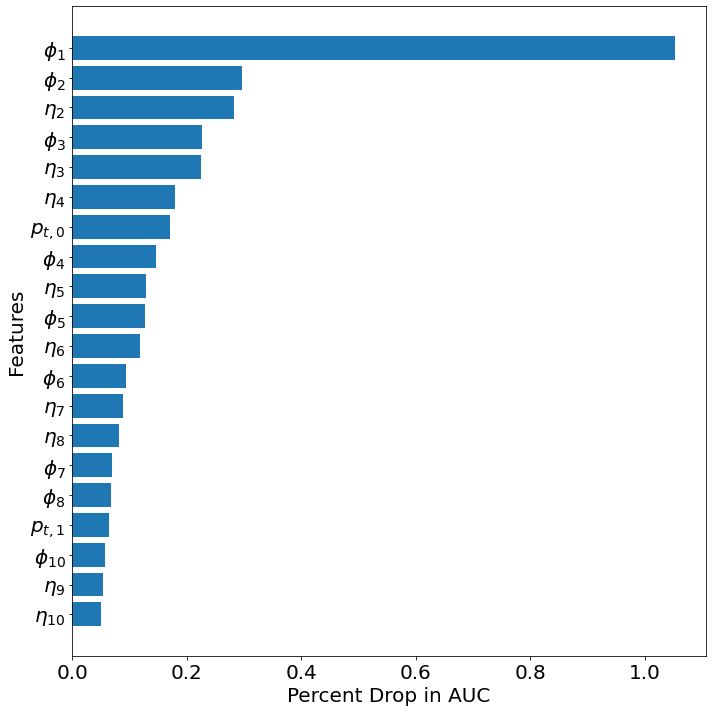

In [9]:
sorted_tags = []
sorted_vals = []
for val, tag in sorted(zip(dAUC_vals, tag_labels), reverse = True)[:20]:
    sorted_tags.append(tag)
    sorted_vals.append(val)

dAUC_chart(sorted_vals, sorted_tags, tag=mode, save=True)

In [10]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.nanquantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

def plotmaker(data, tags, plot_type = 'abs_bar', part_dataset = 'bkg', save = False, options = ""):
    if plot_type == 'abs_bar':
        data_no_outlier = removeOutliers(data)
        plt.figure(figsize=(10,10))
        abs_data = np.nanmean(np.abs(data_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=tags, rels=abs_data))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 20
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        #plt.tight_layout()
        plt.xlabel("MAD Relevance Score", fontsize=20)
        plt.ylabel("Features", fontsize=20)
        #plt.locator_params(axis='x', nbins=7)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.tight_layout()
        # plt.title("TopoDNN Absolute Value "+type_set+" Delta LRP values")
        if save:
            plt.savefig("figures/dLRP_TopoDNN"+mode+"_"+part_dataset+"_absbar"+options+".png", 
                        dpi = 150, bbox_inches='tight')
        plt.show()
    if plot_type == 'box_whisker':
        plt.figure(figsize=(10,10))
        df_rel_total = pd.DataFrame(removeOutliers(data), columns=tags)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(data, columns=tags)
        df_rel_total = df_rel[sorted_index[:20]]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        #plt.title("TopoDNN "+type_set+" LRP Box and Whisker Distribution")
        #plt.tight_layout()
        if save:
            plt.savefig("figures/dLRP_TopoDNN"+mode+"_"+part_dataset+"_boxwhisker"+options+".png",
                        dpi = 150, bbox_inches='tight')
        plt.show()

In [11]:
dresult = np.transpose(np.array(dresult))
dresult_presig = np.transpose(np.array(dresult_presig))

In [12]:
inds_bkg = labels==0
inds_sig = labels==1
dresult_bkg = dresult[inds_bkg, :]
dresult_presig_bkg = dresult_presig[inds_bkg, :]
dresult_sig = dresult[inds_sig, :]
dresult_presig_sig = dresult_presig[inds_sig, :]

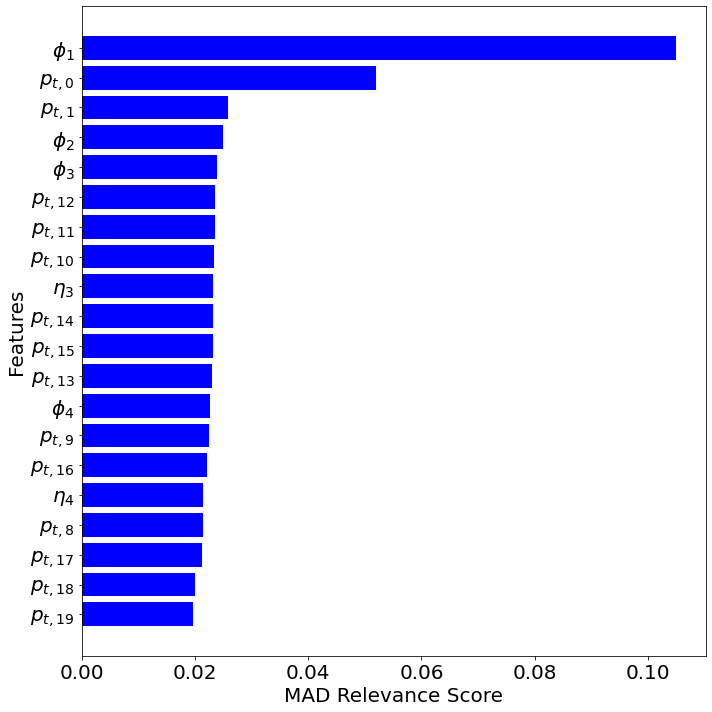

In [13]:
plotmaker(dresult_presig_bkg, tag_labels, plot_type = 'abs_bar', 
          part_dataset = 'bkg', options = "_presigmoid", save = True)
#plotmaker(dresult_bkg, tag_labels, plot_type = 'abs_bar', 
#          part_dataset = 'bkg', options = "", save = False)

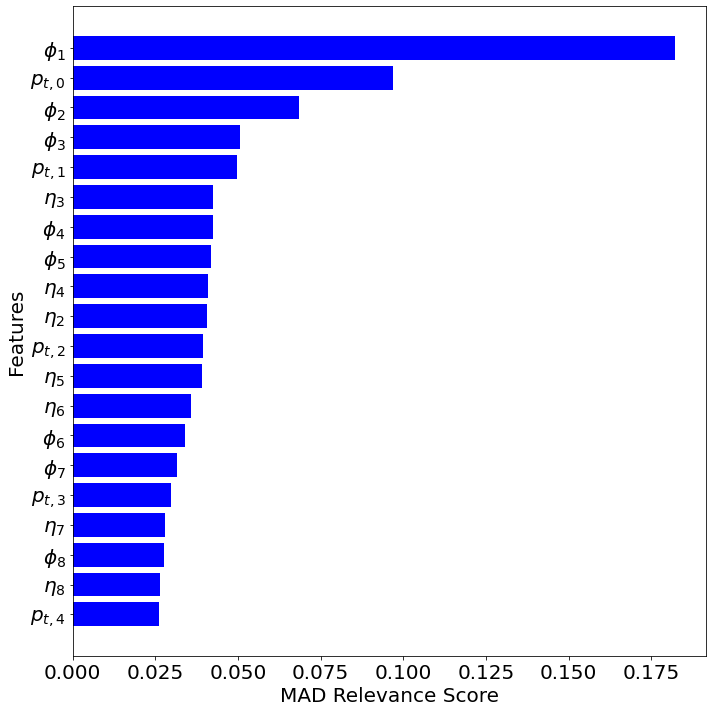

In [14]:
plotmaker(dresult_presig_sig, tag_labels, plot_type = 'abs_bar', 
          part_dataset = 'sig', options = "_presigmoid", save = True)
#plotmaker(dresult_sig, tags, plot_type = 'abs_bar', 
#          part_dataset = 'sig', options = "", save = False)